## 0. CNN 모델 설계 순서

>1. 모듈 임포트  
2. 장비 확인  
3. 데이터 다운로드  
4. 데이터 확인  
5. MLP 설계  
6. Optimizer, Objective Function 설정    
7. 학습 데이터에 대한 모델 성능 확인하는 함수 정의  
8. 검증 데이터에 대한 모델의 성능을 확인하는 함수 정의  
9. 모델 학습 및 성능 확인  

## 1. 모듈 임포트

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

from torchsummary import summary

## 2. 장비 확인

In [21]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
    
print('Using Pytorch version:', torch.__version__, 'Device : ', DEVICE)

Using Pytorch version: 1.9.0 Device :  cpu


In [22]:
BATCH_SIZE = 32 
EPOCHS = 10

## 3. CIFAR10 데이터 다운로드(Train/Test 분리)

- CIFAR_10 데이터 셋은 **컬러 이미지 데이터**이다. 데이터를 다운로드할 때 이미지 데이터에 대한 **기본적인 전처리**를 동시에 진행한다.  
- ToTensor() 메서드를 이용해 **텐서 형태로 데이터를 변경**하고, **픽셀을 0과 1 사이의 값으로 정규화**한다.
- 모델이 정보의 순서를 암기해 학습을 진행하는 것을 방지하고자 **shuffle = True**로 설정한다.


### Data Augmentation

- 복잡한 모델을 만들기 위해서는 다량의 데이터가 필요하다.
- 갖고 있는 **한정적인 데이터를 임의로 변형해 데이터의 수를 늘려 다양한 Feature를 뽑는 것**을 **Data Augmentation**이라 한다.
- Data Augmentation을 사용하면 성능이 소폭 상승한다.
- 학습 데이터에 이용하는 전처리 과정은 검증 데이터에도 동일하게 적용돼야 한다. 

>- transforms.Compose() : 이미지 데이터에 전처리 및 Augmentation으 다양하게 적용
>- RandomHorizontalFlip() : 해당 이미지를 50% 확률로 좌우 반전
>- ToTensor() : 0과 1사이의 값으로 정규화하고 텐서 형태로 이미지 변환
>- Normalize() : 텐서 형태로 전환된 이미지에 대해 또 다른 정규화 진행. r,g,b 순서로 평균 0.5, 표준편차 0.5씩 적용.

In [23]:
train_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                train = True,
                                download = True,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
                                )

test_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
                                )

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

Files already downloaded and verified


## 4. 데이터 확인

- 훈련용 데이터 50,000개, 테스트용 데이터 10,000개
- 훈련용 데이터의 미니배치 개수는 1563, 테스트용 데이터의 미니배치 개수는 313
- **하나의 미니배치(X_train)**에는 **32개의 이미지 데이터**가 존재
- **하나의 이미지 데이터**는 **가로 32개, 세로 32개의 픽셀**로 이뤄져있고 **채널은 3(RGB)** 

In [24]:
print("train_dataset : ", len(train_loader.dataset))
print("test_dataset : ", len(test_loader.dataset))

print("train_loader : ", len(train_loader)) # 미니배치 개수 = iteration 횟수
print("test_loader : ", len(test_loader)) # 미니배치 개수 = iteration 횟수

train_dataset :  50000
test_dataset :  10000
train_loader :  1563
test_loader :  313


In [25]:
for(X_train, y_train) in train_loader:
    # Mini-batch 1개 안의 데이터 확인
    print('X_train:', X_train.size(), 'type:',X_train.type())
    print('y_train:', y_train.size(), 'type:',y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

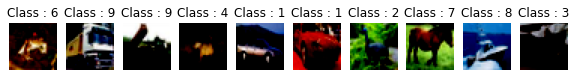

In [26]:
# 데이터 시각화
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i],(1,2,0)))
    plt.title('Class : ' + str(y_train[i].item()))

In [27]:
print('before np.transpose : ', X_train[0].size())
print('after np.transpose : ',np.transpose(X_train[i],(1,2,0)).size())

before np.transpose :  torch.Size([3, 32, 32])
after np.transpose :  torch.Size([32, 32, 3])


## 5. CNN 설계

- MLP 모델의 input으로 이용될 때 이미지 데이터는 1차원으로 펼쳐 이용된다. 즉, 이미지 내에 지역적인 특징을 반영할 수 없다.
- **컬러 이미지**인 경우에는 채널이 3개나 되며, **32x32x3 크기의 데이터를 1차원으로 펼쳐놓게 되면 이미지의 특성을 잃어버릴 수 있다.**
- 따라서 1차원으로 펼치는 것(기존 MLP)이 아니라 **이미지와 주변 픽셀의 조합을 통해 특징을 추출하는 CNN 모형**을 사용한다.

**첫 번째 convolution**
>- Filter의 채널 수는 입력 이미지의 채널 수와 동일하게 설정한다. 
>- Filter의 개수는 8로 설정. 이 개수만큼 Output(Feature Map)의 depth가 결정된다.
>- Filter의 크기는 3 * 3
>- 이미지 픽셀의 구석 부분과 중앙 부분이 convolution 연산되는 횟수를 동일하게 맞춰주기 위해 zero padding = 1로 설정


**두 번째 convolution**
>- Feature Map의 채널 수와 동일한 채널 수를 설정한다.
>- Filter의 개수는 16으로 설정
>- Filter의 크기는 3 * 3
>- 이미지 픽셀의 구석 부분과 중앙 부분이 convolution 연산되는 횟수를 동일하게 맞춰주기 위해 zero padding = 1로 설정

**Pooling Layer**
>- convolution을 통해 Feature Map이 생성됐을 때, 모든 Feature Map을 이용하는 것이 아니라 부분적으로 이용한다.(**다운샘플링**)
>- 생성된 Feature Map 위에서 2 * 2 크기의 Filter(커널)가 돌아다니면서 가장 큰 Feature Map 값을 추출한다.
>- Filter가 Feature Map 위에서 움직이는 단위(간격)은 2로 설정한다.

**MLP**
>- 이미지 내 주변 픽셀과의 조합을 가장 잘 반영할 수 있는 Feature Map을 추출하고난 후, 이를 기존의 MLP 모델에 input으로 사용한다. 
>- 2개의 convolution 연산을 거친 후 최종적으로 만들어지는 Feature Map의 크기는 **8 * 8 * 16**이다. **8 * 8 크기의 2차원 데이터가 16개 겹쳐 있는 형태**로 존재한다.
>- Feature Map을 1차원으로 펼친 후 여러 층의 Fully Connected Layer를 통과시킨다.
>- 두 번째 Fully Connected Layer의 노드 수는 64, 세 번째 Fully Connected Layer의 노드 수는 32, 최종 Output은 10으로 설정한다.
>- 최종 출력층에는 log_softmax 함수를 적용하여 확률 값을 계산한다.

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(
                              in_channels = 3,
                              out_channels = 8, # filter 개수
                              kernel_size = 3,
                              padding = 1)
        
        self.conv2 = nn.Conv2d(in_channels = 8,
                              out_channels = 16,
                              kernel_size = 3,
                              padding = 1)
        
        self.pool = nn.MaxPool2d(kernel_size = 2,
                                stride = 2)
        
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x
        

## 6. Optimizer, Objective Function 설정

- CNN 모델을 DEVICE에 할당
- 최적화 방식은 Adam
- 최적화에 사용될 손실함수는 CrossEntropyLoss

In [29]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [30]:
# print(model)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
         MaxPool2d-2            [-1, 8, 16, 16]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Linear-5                   [-1, 64]          65,600
            Linear-6                   [-1, 32]           2,080
            Linear-7                   [-1, 10]             330
Total params: 69,402
Trainable params: 69,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.26
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


<ipython-input-28-27e54b7f2b0a>:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


## 7. 학습 데이터에 대한 모델 성능 확인하는 함수 정의

1. CNN 모델을 학습 상태로 지정
2. Mini-batch 단위로 저장된 데이터를 순서대로 이용하여 모델 학습
3. 이미지 데이터와 레이블 데이터를 기존에 정의한 장비에 할당
4. Optimizer 초기화
5. output 계산 
6. CrossEntropy를 통해 Loss 계산
7. Backpropagation을 통한 파라미터 업데이트

In [31]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    print("------------------------- Training..... -------------------------\n")
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step() # 파라미터 업데이트
        
        if batch_idx % log_interval == 0 :
            print("Train Epoch: {} [{}/{}]\tTrain Loss: {:.6f}".format(Epoch,
                                                                       len(image) * batch_idx,
                                                                       len(train_loader.dataset),
                                                                       loss.item()))
    print("------------------------------------------------------------------\n")   

## 8. 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

1. 모델을 평가 상태로 지정
2. Gradient의 흐름을 억제하여 파라미터 값이 업데이트되는 현상 방지
3. 이후 과정은 *7. 학습 데이터에 대한 모델 성능을 확인하는 함수 정의* 와 동일

In [32]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            test_loss += criterion(output, label)
            prediction = output.max(1, keepdim = True)[1] # 가장 큰 확률 값을 지니는 클래스의 인덱스만 추출
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

## 9. 모델 학습 및 성능 확인

In [33]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("[EPOCH: {}] Test Loss: {:.4f} \tTest Accracy: {:.2f}%\n".format(Epoch,
                                                                            test_loss,
                                                                            test_accuracy))

------------------- Training..... -------------------

Train Epoch: 1 [0/50000]	Train Loss: 2.329477


<ipython-input-28-27e54b7f2b0a>:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [6400/50000]	Train Loss: 1.746234
Train Epoch: 1 [12800/50000]	Train Loss: 1.469539
Train Epoch: 1 [19200/50000]	Train Loss: 1.835317
Train Epoch: 1 [25600/50000]	Train Loss: 1.269000
Train Epoch: 1 [32000/50000]	Train Loss: 1.484481
Train Epoch: 1 [38400/50000]	Train Loss: 1.503568
Train Epoch: 1 [44800/50000]	Train Loss: 1.444030
------------------------------------------------------

[EPOCH: 1] 	Test Loss: 0.0417 	Test Accracy: 52.12%

------------------- Training..... -------------------

Train Epoch: 2 [0/50000]	Train Loss: 1.352624
Train Epoch: 2 [6400/50000]	Train Loss: 1.304258
Train Epoch: 2 [12800/50000]	Train Loss: 1.038000
Train Epoch: 2 [19200/50000]	Train Loss: 1.543259
Train Epoch: 2 [25600/50000]	Train Loss: 0.948478
Train Epoch: 2 [32000/50000]	Train Loss: 1.237942
Train Epoch: 2 [38400/50000]	Train Loss: 1.146048
Train Epoch: 2 [44800/50000]	Train Loss: 1.165063
------------------------------------------------------

[EPOCH: 2] 	Test Loss: 0.0366 	Test 